In [25]:
import json

# Assuming dict_res1 and dict_res2 are your dictionaries
dict_res1 = {'key1': 'value1', 'key2': 'value2'}
dict_res2 = {'key2': 'value3', 'key4': 'value4'}
dict1 = {}
# Concatenate the JSON strings together
concatenated_json = {**dict1, **dict_res2}  # Add newline for better readability
concatenated_json

{'key2': 'value3', 'key4': 'value4'}

In [26]:
# Daily Looping
from backtesting import Backtest, Strategy
import yfinance as yf
import json
import pandas as pd
import datetime
import pandas_ta as ta
import tqdm
import subprocess
route = "../Database/"
filemap = {
    "NYSE"  : route + "../Database/zackRanks_NYSE.json", # 1352
    "NASDAQ": route + '../Database/zackRanks_NASDAQ.json', # small:1255; mid:330; large:72
    "SP500" : route + "../Database/zackRanks_SP500.json", # small: 1352
   "Yuanta": route + "zackRanks_yuanta.json",
   "buy": route + "buy.json",
   "sell": route + "sell.json",
   "portfolio": route + "zackRanks_portfolio.json"
}
def get_tickers(file="SP500"):
    dict = pd.read_csv(filemap[file], header=None)
    dict = dict.iloc[:, 0]
    return dict

def WPRbt(data):
    period = 12
    max = data.Close.rolling(period).max()
    min = data.Close.rolling(period).min()
    wpr = (max - data.Close)/(max - min) * (-100) 
    return wpr

def check_WPR_2MA_without_DB(ticker, test=False, period_long_ma=28, period_short_ma=14, upb=-20, lob=-80):
    a = yf.download(ticker, start=datetime.datetime.now() - datetime.timedelta(days=50), interval="1d", progress=False)

    # a["WPR"] = WPRbt(a)
    a["MAX"] = a.High.rolling(12).max()
    a["MIN"] = a.Low.rolling(12).min()
    a["WPRs"] = (a.MAX - a.Close)/(a.MAX - a.MIN) * (-100)
    a["long_MA"] = a.Close.ewm(span=period_long_ma, adjust=False, min_periods=period_long_ma).mean()
    a['short_MA'] = a.Close.ewm(span=period_short_ma, adjust=False, min_periods=period_short_ma).mean()
    long0 = a['long_MA'][-1]
    long1 = a['long_MA'][-2]
    long2 = a['long_MA'][-3]
    long3 = a['long_MA'][-4]
    # =======================
    short0 = a['short_MA'][-1]
    short1 = a['short_MA'][-2]
    short2 = a['short_MA'][-3]
    short3 = a['short_MA'][-4]
    # =======================
    wpr0 = a['WPRs'][-1]
    wpr1 = a['WPRs'][-2]
    wpr2 = a['WPRs'][-3]
    wpr3 = a['WPRs'][-4]
    check_ma_percent = 0.0000# for PAYX at 2024-02-08, 0.005 return 4(meaning doesn't work ) while 0.006 works
    bear_market = (long0 - short0 > long0*check_ma_percent) and (long1 - short1 > long1*check_ma_percent) and (long2 - short2 > long2*check_ma_percent)
    bull_market = (long0 - short0 < long0*-check_ma_percent) and (long1 - short1 < long1*-check_ma_percent) and (long2 - short2 < long2*-check_ma_percent)
    if test:
        print(a[['Close', "short_MA", "long_MA", "WPRs", "MAX"]])
        print(wpr0, wpr1, wpr2, wpr3)
        print("quick: ", [short3, short2, short1, short0])
        print("slow: ", [long3, long2, long1, long0])
    # current signal
    if((wpr0 < upb) and (wpr1 > upb) and bear_market):
        # print(ticker, "cross above"):
            # sell signal
        return 1
    elif ((wpr0 > lob) and (wpr1 < lob)) and bull_market:
        # buy signal
        return 2
    # check for yesterday or the day before yesterday buy/sell signal
    elif((wpr1 < upb) and (wpr2 > upb) and bear_market):
        return 1.5
    elif((wpr1 > lob) and (wpr2 < lob) and bull_market):
        return 2.5
    elif((wpr2 > lob) and (wpr3 < lob) and bull_market) or ((wpr2 > upb) and (wpr3 < upb) and bear_market):
        return 3

    else:
        return 0
# if __name__ == "__main__":
# TradingView Missed; Python Passed => Correct Signal: VLTO
# print(check_WPR_2MA_without_DB("VSTS", test=True))
def mains(loops = ["NYSE", "Yuanta", "NASDAQ", "SP500"], updateDatabase = False):
    all_signals = {}
    sell_of_the_day = []
    buy_of_the_day = []
    for k in loops:
        print("*"*20, k, "*"*20)
        if k not in ["zack1", "zack2"]:
            # print(a)
            with open(filemap[k], 'r') as f:
            ## 轉成Python Dict
                python_dict = json.load(f)
            a = list(python_dict.keys())
            if k in ['portfolio', "SP500", "Yuanta"]:
                tickers = a[:]
            elif k == "NYSE":
                tickers = a[1:1352]
            elif k == "NASDAQ":
                tickers = a[1:1255]
        elif k == "zack2":
            tickers = [
        'MSFT', 'NVDA', 'JPM',  'MA',   'COST', 'IBM',  'QCOM', 'UBER',
        'ELV',  'AXP',  'SYK',  'LRCX', 'BLK',  'MDLZ', 'CB',   'ETN',
        'MU',   'BSX',  'CI',   'CDNS', 'EQIX', 'CME',  'DUK',  'ICE',
        'BDX',  'CL',   'MCK',  'ANET', 'TGT',  'NOC',  'PH',   'GM',
        'CTAS', 'EMR',  'LULU', 'TRV',  'EW',   'DXCM', 'AFL',  'TEL',
        'ALL',  'CNC',  'GWW',  'PAYX', 'FAST', 'CEG',  'COR',  'AME',
        'RSG',  'XEL',  'KMI',  'VICI', 'FICO', 'FTV',  'CAH',  'ZBH',
        'HIG',  'HPQ',  'CHD',  'AWK',  'WAB',  'STT',  'HWM',  'DTE',
        'DRI',  'CBOE', 'VTR',  'WDC',  'STLD', 'BRO',  'HOLX', 'CINF',
        'PFG',  'VLTO', 'WRB',  'CCL',  'STX',  'NTRS', 'SYF',  'JBL',
        'MAS',  'LDOS', 'LW',   'CE',   'NDSN', 'GEN',  'LNT',  'JKHY',
        'TAP',  'FFIV', 'GL',   'NI',   'QRVO', 'UHS',  'AAL',  'TPR',
        'AIZ',  'BEN',  'FRT',  'DVA'
        ]
        elif k == "zack1":
            tickers = [
        'AMZN', 'META', 'NFLX',
        'PGR',  'ABNB', 'HCA',
        'PCAR', 'BK',   'OKE',
        'RCL',  'TROW', 'NVR',
        'CLX',  'TXT',  'TSN',
        'HII',  'RL',   'GPS'
        ]

        if k in ['portfolio']:
            print(tickers)
            dict_res = {}
            for ticker in tickers:
                command = "zacks-api " + ticker
                result = subprocess.check_output(command, shell=True)
                dict = eval(result.decode(("utf-8")))
                dict_res[ticker] = dict['zacksRank']
            print(dict_res)
            return None
        # Using tqdm to add a progress bar
        with tqdm.tqdm(total=len(tickers)) as pbar:
            res = {}
            for ticker in tickers:
                res[ticker] = check_WPR_2MA_without_DB(ticker)
                pbar.update(1)  # Update the progress bar

        s = [{i:res[i]} for i in res.keys() if res[i] != 0 ]
        if sum(list(res.values())) == 0:
            print("there's nothing with signal")

        checks = [1, 2]
        for check in checks:
            q = [i for i in res.keys() if res[i] == check]
            q
            dict_res = {}
            print(len(q))
            for ticker in q:
                command = "zacks-api " + ticker
                result = subprocess.check_output(command, shell=True)
                dict = eval(result.decode(("utf-8"))) 
                
                dict_res[ticker] = dict['zacksRank']
            if check == 1:
                # print("sell")
                sell = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "4"]
                strong_sell = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "5"]
                print("Strong Sell:", strong_sell)
                print("Sell: ", sell)
                res_sell = strong_sell #+ sell
                sell_of_the_day += strong_sell
            if check == 2:
                # print("buy")
                strong_buy = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "1"]
                buy = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "2"]
                hold_but_signal = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "3"]
                print("Strong Buy:", strong_buy)
                print("Buy: ", buy)
                res_buy = strong_buy #+ buy
                buy_of_the_day += strong_buy
            print(json.dumps(dict_res, indent=4))
            print("=============")
        all_signals = {**all_signals, **dict_res}
        if updateDatabase:
            with open(filemap['buy'], 'r') as f:
            ## 轉成Python Dict
                python_dict = json.load(f)
            time = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
            python_dict[k][time] = res_buy

            with open(filemap['buy'], 'w') as f:
                json.dump(python_dict, f, indent=4)

            with open(filemap['sell'], 'r') as f:
                python_dict_sell = json.load(f)
            python_dict_sell[k][time] = res_sell

            with open(filemap['sell'], 'w') as f:
                json.dump(python_dict_sell, f, indent=4)
    print("Sell: ", sell_of_the_day)
    print("Buy: ", buy_of_the_day)
    print("Hold: ", hold_but_signal)
    print("all signals", all_signals)
updateDatabase = True

loops = ["NYSE", "Yuanta", "NASDAQ", "SP500"]
mains(updateDatabase=updateDatabase, loops=loops)


******************** NYSE ********************


  1%|          | 9/1351 [00:01<03:06,  7.19it/s]

In [14]:
import json
import subprocess
route = "../Database/"
filemap = {
    "NYSE"  : route + "../Database/zackRanks_NYSE.json", # 1352
    "NASDAQ": route + '../Database/zackRanks_NASDAQ.json', # small:1255; mid:330; large:72
    "SP500" : route + "../Database/zackRanks_SP500.json", # small: 1352
   "Yuanta": route + "zackRanks_yuanta.json",
   "buy": route + "buy.json",
   "sell": route + "sell.json",
   "portfolio":route + "zackRanks_portfolio.json"
}
dict_res = {}
with open(filemap["portfolio"], 'r') as f:
## 轉成Python Dict
    python_dict = json.load(f)
q = list(python_dict.keys())

for ticker in q:
    command = "zacks-api " + ticker
    result = subprocess.check_output(command, shell=True)
    dict = eval(result.decode(("utf-8"))) 
    
    dict_res[ticker] = dict['zacksRank']
dict_res

{'EWTX': '2',
 'EXAS': '1',
 'FMX': '1',
 'EDRY': '1',
 'FFIN': '1',
 'FFIV': '2',
 'HRMY': '1',
 'IBKR': '2',
 'KMPR': '1',
 'NVGS': '3',
 'OGN': '1',
 'PANL': '1',
 'SHOP': '2',
 'NFLX': '1',
 'XRX': '1',
 'CE': '2',
 'CX': '1'}

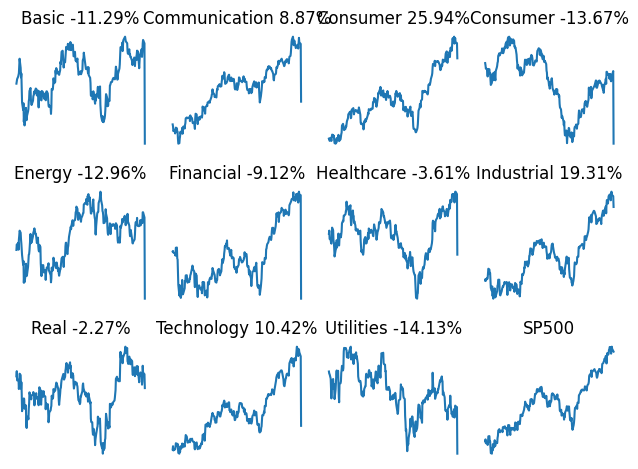

monthly : ['Industrial', 'Real', 'Healthcare', 'Consumer', 'Utilities']
3 months : ['Industrial', 'Real', 'Healthcare', 'Consumer', 'Utilities']
6  months : ['Industrial', 'Real', 'Communication', 'Technology', 'Financial']
yearly : ['Industrial', 'Technology', 'Communication', 'Real', 'Healthcare']


In [15]:
# Trend Comparison
# 30 secsce
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf 
import json
import datetime
with open("../Database/us_stock.json", "r") as f:
  python_dict = json.load(f)
dict_return_comparison = {}
mat = list(python_dict["SP500"].keys())
fig, ax = plt.subplots(3, 4)
start = datetime.datetime.now() - datetime.timedelta(days=365)
for i, bas in enumerate(mat):
  
  a = yf.download(python_dict["SP500"][bas], start=start, progress=False)
  close = a["Close"]
  avg = close.sum(axis=1)/len(close.columns)
  percentage_change_year = round(((avg[-1]-avg[0])/avg[0])*100, 2)
  percentage_change_month = round(((avg[-1]-avg[-30])/avg[0])*100, 2)
  percentage_change_3m = round(((avg[-1]-avg[-90])/avg[0])*100, 2)
  percentage_change_6m = round(((avg[-1]-avg[-180])/avg[0])*100, 2)
  class_name = bas.split(" ")[0]
  dict_return_comparison[class_name] = [percentage_change_month, percentage_change_3m, percentage_change_6m, percentage_change_year]
  title = class_name + " " + str(percentage_change_year) + "%"
  if 0 <= i <= 3:
    ax[0, i].plot(avg)
    ax[0, i].set_title(title)
    ax[0, i].axis("off")
  if 4 <= i <= 7:
    ax[1, i-4].plot(avg)
    ax[1, i-4].set_title(title)
    ax[1, i-4].axis("off")
  if 8 <= i <= 10:
    ax[2, i-8].plot(avg)
    ax[2, i-8].set_title(title) 
    ax[2, i-8].axis("off")
k = yf.download("^GSPC",start=start, progress=False)
ax[2, 3].plot(k['Close'])
ax[2, 3].set_title("SP500")
ax[2, 3].axis("off")
plt.tight_layout()
plt.show()

comp = {
    0: "monthly",
    1: "3 months",
    2: "6  months",
    3: "yearly"
}
def geykey(item):
    return item[1]
list_ = [0, 1, 2, 3]
for interval in list_:

    sorted_dict = sorted(dict_return_comparison.items(), key=lambda x:x[1][interval], reverse=True)
    returns = {}
    for i, value in enumerate(sorted_dict):
        returns[value[0]] = dict_return_comparison[value[0]]
    print(comp[interval], ":", list(returns.keys())[:5])